In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir("/content/drive/MyDrive")

In [ ]:
!pip install click opencv-python matplotlib tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!git clone https://github.com/kazuto1011/grad-cam-pytorch.git

Cloning into 'grad-cam-pytorch'...
remote: Enumerating objects: 755, done.
remote: Total 755 (delta 0), reused 0 (delta 0), pack-reused 755
Receiving objects: 100% (755/755), 43.58 MiB | 3.43 MiB/s, done.
Resolving deltas: 100% (96/96), done.


In [ ]:
import math
import torch
from torch import nn
from torch.nn import functional as F
import torch.optim as optim
import torchsummary
from torchsummary import summary
import torchvision
from torchvision import transforms, datasets

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # set gpu

In [ ]:
print(device)

cuda:0


In [ ]:
def relu_fn(x):
    """ Swish activation function """
    return x * torch.sigmoid(x)

In [ ]:
class Conv2dSamePadding(nn.Conv2d):
    """ 2D Convolutions like TensorFlow """
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, dilation=1, groups=1, bias=True):
        super().__init__(in_channels, out_channels, kernel_size, stride, 0, dilation, groups, bias)

    def forward(self, x):
        ih, iw = x.size()[-2:]
        kh, kw = self.weight.size()[-2:]
        sh, sw = self.stride
        oh, ow = math.ceil(ih / sh), math.ceil(iw / sw)
        pad_h = max((oh - 1) * self.stride[0] + (kh - 1) * self.dilation[0] + 1 - ih, 0)
        pad_w = max((ow - 1) * self.stride[1] + (kw - 1) * self.dilation[1] + 1 - iw, 0)
        if pad_h > 0 or pad_w > 0:
            x = F.pad(x, [pad_w//2, pad_w - pad_w//2, pad_h//2, pad_h - pad_h//2])
        return F.conv2d(x, self.weight, self.bias, self.stride, self.padding, self.dilation, self.groups)


In [ ]:
def drop_connect(inputs, p, training):
    """ Drop connect. """
    if not training: return inputs
    batch_size = inputs.shape[0]
    keep_prob = 1 - p
    random_tensor = keep_prob
    random_tensor += torch.rand([batch_size, 1, 1, 1], dtype=inputs.dtype)  # uniform [0,1)
    binary_tensor = torch.floor(random_tensor)
    binary_tensor = binary_tensor.to(device)
    output = inputs / keep_prob * binary_tensor
    return output

In [ ]:
class MBConvBlock(nn.Module):
    """
    Mobile Inverted Residual Bottleneck Block
    """

    def __init__(self, kernel_size, stride, expand_ratio, input_filters, output_filters, se_ratio, drop_n_add):
        super().__init__()
        
        self._bn_mom = 0.1
        self._bn_eps = 1e-03
        self.has_se = (se_ratio is not None) and (0 < se_ratio <= 1)
        self.expand_ratio = expand_ratio
        self.drop_n_add = drop_n_add

        # Filter Expansion phase
        inp = input_filters  # number of input channels
        oup = input_filters * expand_ratio  # number of output channels
        if expand_ratio != 1: # add it except at first block 
            self._expand_conv = Conv2dSamePadding(in_channels=inp, out_channels=oup, kernel_size=1, bias=False)
            self._bn0 = nn.BatchNorm2d(num_features=oup, momentum=self._bn_mom, eps=self._bn_eps)

        # Depthwise convolution phase
        k = kernel_size
        s = stride
        self._depthwise_conv = Conv2dSamePadding(
            in_channels=oup, out_channels=oup, groups=oup,  # groups makes it depthwise(conv filter by filter)
            kernel_size=k, stride=s, bias=False)
        self._bn1 = nn.BatchNorm2d(num_features=oup, momentum=self._bn_mom, eps=self._bn_eps)

        # Squeeze and Excitation layer, if desired
        if self.has_se:
            num_squeezed_channels = max(1,int(input_filters * se_ratio))  # input channel * 0.25 ex) block2 => 16 * 0.25 = 4
            self._se_reduce = Conv2dSamePadding(in_channels=oup, out_channels=num_squeezed_channels, kernel_size=1)
            self._se_expand = Conv2dSamePadding(in_channels=num_squeezed_channels, out_channels=oup, kernel_size=1)

        # Output phase
        final_oup = output_filters
        self._project_conv = Conv2dSamePadding(in_channels=oup, out_channels=final_oup, kernel_size=1, bias=False)
        self._bn2 = nn.BatchNorm2d(num_features=final_oup, momentum=self._bn_mom, eps=self._bn_eps)
    def forward(self, inputs, drop_connect_rate=0.2):

        # Expansion and Depthwise Convolution
        x = inputs
        if self.expand_ratio != 1:
            x = relu_fn(self._bn0(self._expand_conv(inputs)))
        x = relu_fn(self._bn1(self._depthwise_conv(x)))

        # Squeeze and Excitation
        if self.has_se:
            x_squeezed = F.adaptive_avg_pool2d(x, 1)
            x_squeezed = self._se_expand(relu_fn(self._se_reduce(x_squeezed)))
            x = torch.sigmoid(x_squeezed) * x
            
        # Output phase
        x = self._bn2(self._project_conv(x))

        # Skip connection and drop connect
        if self.drop_n_add == True:
            if drop_connect_rate:
                x = drop_connect(x, p=drop_connect_rate, training=self.training)
            x = x + inputs  # skip connection
        return x

In [ ]:
class EfficientNet(nn.Module):
    def __init__(self):
        super().__init__()

        # Batch norm parameters
        bn_mom = 0.1
        bn_eps = 1e-03

        # stem
        in_channels = 3
        out_channels = 32
        self._conv_stem = Conv2dSamePadding(in_channels, out_channels, kernel_size=3, stride=2, bias=False)
        self._bn0 = nn.BatchNorm2d(num_features=out_channels, momentum=bn_mom, eps=bn_eps)

        # Build blocks
        self._blocks = nn.ModuleList([]) # list 형태로 model 구성할 때
        # stage2 r1_k3_s11_e1_i32_o16_se0.25
        self._blocks.append(MBConvBlock(kernel_size=3, stride=1, expand_ratio=1, input_filters=32, output_filters=16, se_ratio=0.25, drop_n_add=False))
        # stage3 r2_k3_s22_e6_i16_o24_se0.25
        self._blocks.append(MBConvBlock(3, 2, 6, 16, 24, 0.25, False))
        self._blocks.append(MBConvBlock(3, 1, 6, 24, 24, 0.25, True))
        # stage4 r2_k5_s22_e6_i24_o40_se0.25
        self._blocks.append(MBConvBlock(5, 2, 6, 24, 40, 0.25, False))
        self._blocks.append(MBConvBlock(5, 1, 6, 40, 40, 0.25, True))
        # stage5 r3_k3_s22_e6_i40_o80_se0.25
        self._blocks.append(MBConvBlock(3, 2, 6, 40, 80, 0.25, False))
        self._blocks.append(MBConvBlock(3, 1, 6, 80, 80, 0.25, True))
        self._blocks.append(MBConvBlock(3, 1, 6, 80, 80, 0.25, True))
        # stage6 r3_k5_s11_e6_i80_o112_se0.25
        self._blocks.append(MBConvBlock(5, 1, 6, 80,  112, 0.25, False))
        self._blocks.append(MBConvBlock(5, 1, 6, 112, 112, 0.25, True))
        self._blocks.append(MBConvBlock(5, 1, 6, 112, 112, 0.25, True))
        # stage7 r4_k5_s22_e6_i112_o192_se0.25
        self._blocks.append(MBConvBlock(5, 2, 6, 112, 192, 0.25, False))
        self._blocks.append(MBConvBlock(5, 1, 6, 192, 192, 0.25, True))
        self._blocks.append(MBConvBlock(5, 1, 6, 192, 192, 0.25, True))
        self._blocks.append(MBConvBlock(5, 1, 6, 192, 192, 0.25, True))
        # stage8 r1_k3_s11_e6_i192_o320_se0.25
        self._blocks.append(MBConvBlock(3, 1, 6, 192, 320, 0.25, False))

        # Head 
        in_channels = 320
        out_channels = 1280
        self._conv_head = Conv2dSamePadding(in_channels, out_channels, kernel_size=1, bias=False)
        self._bn1 = nn.BatchNorm2d(num_features=out_channels, momentum=bn_mom, eps=bn_eps)

        # Final linear layer
        self._dropout = 0.2
        self._num_classes = 10
        self._fc = nn.Linear(out_channels, self._num_classes)

    def extract_features(self, inputs):
        """ Returns output of the final convolution layer """

        # Stem
        x = relu_fn(self._bn0(self._conv_stem(inputs)))

        # Blocks
        for idx, block in enumerate(self._blocks):          
            x = block(x)
        return x

    def forward(self, inputs):
        """ Calls extract_features to extract features, applies final linear layer, and returns logits. """

        # Convolution layers
        x = self.extract_features(inputs)

        # Head
        x = relu_fn(self._bn1(self._conv_head(x)))
        x = F.adaptive_avg_pool2d(x, 1).squeeze(-1).squeeze(-1)
        if self._dropout:
            x = F.dropout(x, p=self._dropout, training=self.training)
        x = self._fc(x)
        return x

In [ ]:
model = EfficientNet().to(device)
summary(model,(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
 Conv2dSamePadding-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
 Conv2dSamePadding-3         [-1, 32, 112, 112]             288
       BatchNorm2d-4         [-1, 32, 112, 112]              64
 Conv2dSamePadding-5              [-1, 8, 1, 1]             264
 Conv2dSamePadding-6             [-1, 32, 1, 1]             288
 Conv2dSamePadding-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
       MBConvBlock-9         [-1, 16, 112, 112]               0
Conv2dSamePadding-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
Conv2dSamePadding-12           [-1, 96, 56, 56]             864
      BatchNorm2d-13           [-1, 96, 56, 56]             192
Conv2dSamePadding-14              [-1, 

In [ ]:
batch_size = 32

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Tensor Transforms (with Augmentation) and Pytorch Preprocessing:
train_ds = datasets.ImageFolder("/content/drive/MyDrive/cifake/cifake/train", transform=transform)
valid_ds = datasets.ImageFolder("/content/drive/MyDrive/cifake/cifake/valid", transform=transform)
test_ds = datasets.ImageFolder("/content/drive/MyDrive/cifake/cifake/test", transform=transform)

# Data Loaders:
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=2)
valid_loader = torch.utils.data.DataLoader(valid_ds, batch_size=batch_size, shuffle=False,  num_workers=2)
test_loader  = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2)

In [ ]:
# loss
criterion = nn.CrossEntropyLoss()
# backpropagation method
learning_rate = 1e-3
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
# hyper-parameters
num_epochs = 10
num_batches = len(train_loader)

list_epoch = [] 
list_train_loss = []
list_val_loss = []
list_train_acc = []
list_val_acc = []
train_total = 0
val_total= 0
train_correct = 0
val_correct = 0

for epoch in range(num_epochs):
    trn_loss = 0.0
    train_total = 0
    val_total= 0
    train_correct = 0
    val_correct = 0
    for i, data in enumerate(train_loader):
        x, labels = data
        x = x.to(device)
        labels = labels.to(device)
        # grad init
        optimizer.zero_grad()
        # forward propagation
        model_output = model(x)
        # calculate acc
        _, predicted = torch.max(model_output.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        # calculate loss
        loss = criterion(model_output, labels)
        # back propagation 
        loss.backward()
        # weight update
        optimizer.step()
        
        # trn_loss summary
        trn_loss += loss.item()
        # del (memory issue)
        del loss
        del model_output
        if (i+1) % 100 == 0:
            print("epoch: {}/{} | batch: {} | trn loss: {:.4f} | trn acc: {:.4f}%".
                  format(epoch+1, num_epochs, i+1,  trn_loss / i, 100 * train_correct / train_total)) 
        
        # 학습과정 출력
        if (i+1) % 100 == 0: # every 100 mini-batches
            with torch.no_grad(): # very very very very important!!!
                val_loss = 0.0
                for j, val in enumerate(valid_loader):
                    val_x, val_labels = val
                    val_x = val_x.to(device)
                    val_labels = val_labels.to(device)
                    val_output = model(val_x)
                    # calculate acc
                    _, predicted = torch.max(val_output.data, 1)
                    val_total += val_labels.size(0)
                    val_correct += (predicted == val_labels).sum().item()

                    v_loss = criterion(val_output, val_labels)
                    val_loss += v_loss
                       
            print("epoch: {}/{} | batch: {} | trn loss: {:.4f} | trn acc: {:.4f}% | val loss: {:.4f} | val acc: {:.4f}%".
                  format(epoch+1, num_epochs, i+1,  trn_loss / i, 100 * train_correct / train_total, 
                         val_loss / len(valid_loader), 100 * val_correct / val_total))          
    list_epoch.append(epoch+1)
    list_train_loss.append(trn_loss/num_batches)
    list_val_loss.append(val_loss/len(valid_loader))
    list_train_acc.append(100 * train_correct / train_total)
    list_val_acc.append(100 * val_correct / val_total)
    torch.save(model, f'{epoch+1}model.pth')

epoch: 1/10 | batch: 100 | trn loss: 0.4955 | trn acc: 76.7188%
epoch: 1/10 | batch: 100 | trn loss: 0.4955 | trn acc: 76.7188% | val loss: 1.2420 | val acc: 51.8186%
epoch: 1/10 | batch: 200 | trn loss: 0.4559 | trn acc: 79.4844%
epoch: 1/10 | batch: 200 | trn loss: 0.4559 | trn acc: 79.4844% | val loss: 1.0297 | val acc: 51.7879%
epoch: 1/10 | batch: 300 | trn loss: 0.4260 | trn acc: 81.1771%
epoch: 1/10 | batch: 300 | trn loss: 0.4260 | trn acc: 81.1771% | val loss: 1.3946 | val acc: 52.0774%
epoch: 2/10 | batch: 100 | trn loss: 0.3090 | trn acc: 87.5625%
epoch: 2/10 | batch: 100 | trn loss: 0.3090 | trn acc: 87.5625% | val loss: 1.3152 | val acc: 52.2885%
epoch: 2/10 | batch: 200 | trn loss: 0.2891 | trn acc: 88.1094%
epoch: 2/10 | batch: 200 | trn loss: 0.2891 | trn acc: 88.1094% | val loss: 1.4396 | val acc: 51.8696%
epoch: 2/10 | batch: 300 | trn loss: 0.2789 | trn acc: 88.5417%
epoch: 2/10 | batch: 300 | trn loss: 0.2789 | trn acc: 88.5417% | val loss: 1.3912 | val acc: 51.6278

In [ ]:
torch.save(model, '/content/drive/MyDrive/efficientNet_weight/model.pth')

In [ ]:
os.chdir("/content/drive/MyDrive/grad-cam-pytorch")

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
<ipython-input-55-8801e750643e>:33: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  heatmap = (heatmap.astype(np.float) + raw_image.astype(np.float)) / 2


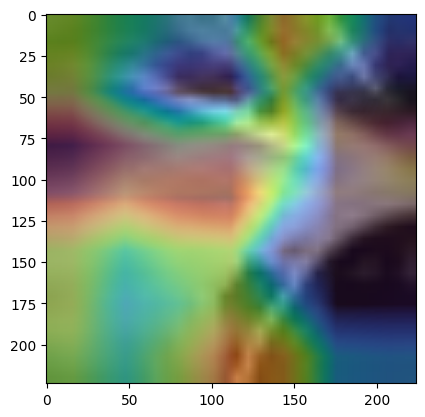

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
from grad_cam import GradCAM

target_layer = "_blocks.15"
model.eval()

# Images
image = Image.open("/content/drive/MyDrive/cifake_local/cifake/valid/fake/valid_fake_0.jpg")
raw_image = np.asarray(transforms.Compose(
    [
       transforms.Resize(224),
    ])(image))
image = transforms.Compose(
    [
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)(image)
images = torch.stack([image]).to(device)

gcam = GradCAM(model=model)
_, sorted_ids = gcam.forward(images)
ids_1st = sorted_ids[:, [0]]

gcam.backward(ids=ids_1st)
heatmap = gcam.generate(target_layer=target_layer)
heatmap = heatmap.cpu().numpy().squeeze()
heatmap = cm.turbo(heatmap)[..., :3] * 255.0
heatmap = (heatmap.astype(np.float) + raw_image.astype(np.float)) / 2
plt.imshow(np.uint8(heatmap))
plt.show()

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


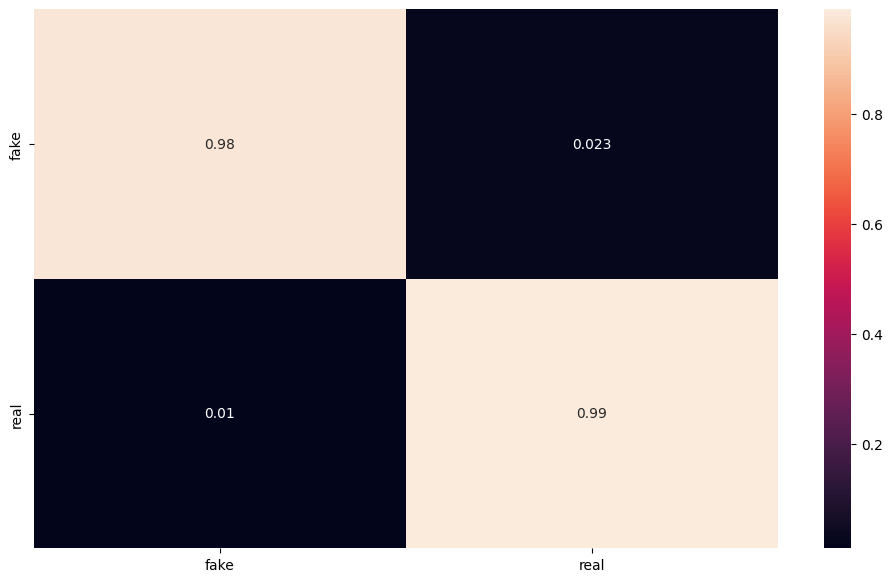

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for data in test_loader:
  x, labels = data
  x = x.to(device)
  labels = labels.to(device)
  output = model(x) # Feed Network

  output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
  y_pred.extend(output) # Save Prediction

  labels = labels.data.cpu().numpy()
  y_true.extend(labels) # Save Truth

# constant for classes
classes = ('fake','real')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')